# Seminar 3:  Dynamic Programming and Monte Carlo methods

## Iterative policy evaluation
### Gridworld problem 
The problem is described in the lecture and in **Example 4.1** in Sutton & Barto. 

![alt text](./graphs/girdworld.png)

- This is a undiscounted episodic task
- Action set for state s: A(s) = {up, down, left, right}
- Actions that would take the agent off the grid leave the state unchanged
- Reward of value -1 for each transition

**Iterative update rule:** Iterative update for the value function whose limit is the solution of the Bellman equation for the value function under a given policy $\pi$ is given by

$$
\begin{align*}V_{k+1}(s)&=\mathbb{E}_{\pi}[r_{t+1}+\gamma{V_k(s_{t+1})|s_t=s]}\\&=\sum_a\pi(s,a)\sum_{s'}P_{s,s'}^a[R_{s,s'}^a+\gamma{V_k(s')}]\end{align*}
$$
for $s \in S$.

### Iterative policy evaluation
Assume that the initial policy is uniform, we then implement the iterative policy evaluation algorithm using this "look-up table": 

<img src="./graphs/algo_iterative_policy.png" width="750" height="550"/>


As we know, algorithms that fall into the category of Dynamic Programming assume that the agent has a prefect knowledge of the environment, i.e., the transition probabilities and expected rewards are known. In order to compute the state values, we first need to learn the environment.


### The environment
First, enumerate the actions and define the number of states, actions, rows and columns.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

up = 0
right = 1
left = 2
down = 3

n_states = 16
n_actions = 4
max_row = 4
max_col = 4

The following code is one of the ways to build the GridWorld environment. The output corresponds to the transition matrix. For more information about `nditer`, please refer to https://numpy.org/doc/stable/reference/arrays.nditer.html#arrays-nditer. 


In [2]:
def grid_world():
    p = {}
    grid = np.arange(n_states).reshape([max_row, max_col])
    it = np.nditer(grid, flags=['multi_index'])

    with it:
        while not it.finished:
            s = it.iterindex
            row, col = it.multi_index

            p[s] = {a: [] for a in range(n_actions)}

            is_done = lambda x: x == 0 or x == (n_states - 1)
            reward = 0.0 if is_done(s) else -1.0

            if is_done(s):
                # 3 variables: next state, reward, done
                p[s][up] = [(s, reward, True)]
                p[s][right] = [(s, reward, True)]
                p[s][left] = [(s, reward, True)]
                p[s][down] = [(s, reward, True)]

            else:
                s_up = s if row == 0 else s - max_row
                s_right = s if col == (max_col - 1) else s + 1
                s_left = s if col == 0 else s - 1
                s_down = s if row == (max_row - 1) else s + max_row

                p[s][up] = [(s_up, reward, is_done(s_up))]
                p[s][right] = [(s_right, reward, is_done(s_right))]
                p[s][left] = [(s_left, reward, is_done(s_left))]
                p[s][down] = [(s_down, reward, is_done(s_down))]

            it.iternext()
    return p

In [3]:
grid = np.arange(n_states).reshape([max_row, max_col])
print(grid) 
it = np.nditer(grid, flags=['multi_index'])
for x in it:
    print("%d <%s>" % (x, it.multi_index), end=',')

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
0 <(0, 0)>,1 <(0, 1)>,2 <(0, 2)>,3 <(0, 3)>,4 <(1, 0)>,5 <(1, 1)>,6 <(1, 2)>,7 <(1, 3)>,8 <(2, 0)>,9 <(2, 1)>,10 <(2, 2)>,11 <(2, 3)>,12 <(3, 0)>,13 <(3, 1)>,14 <(3, 2)>,15 <(3, 3)>,

In [4]:
grid_world()

{0: {0: [(0, 0.0, True)],
  1: [(0, 0.0, True)],
  2: [(0, 0.0, True)],
  3: [(0, 0.0, True)]},
 1: {0: [(1, -1.0, False)],
  1: [(2, -1.0, False)],
  2: [(0, -1.0, True)],
  3: [(5, -1.0, False)]},
 2: {0: [(2, -1.0, False)],
  1: [(3, -1.0, False)],
  2: [(1, -1.0, False)],
  3: [(6, -1.0, False)]},
 3: {0: [(3, -1.0, False)],
  1: [(3, -1.0, False)],
  2: [(2, -1.0, False)],
  3: [(7, -1.0, False)]},
 4: {0: [(0, -1.0, True)],
  1: [(5, -1.0, False)],
  2: [(4, -1.0, False)],
  3: [(8, -1.0, False)]},
 5: {0: [(1, -1.0, False)],
  1: [(6, -1.0, False)],
  2: [(4, -1.0, False)],
  3: [(9, -1.0, False)]},
 6: {0: [(2, -1.0, False)],
  1: [(7, -1.0, False)],
  2: [(5, -1.0, False)],
  3: [(10, -1.0, False)]},
 7: {0: [(3, -1.0, False)],
  1: [(7, -1.0, False)],
  2: [(6, -1.0, False)],
  3: [(11, -1.0, False)]},
 8: {0: [(4, -1.0, False)],
  1: [(9, -1.0, False)],
  2: [(8, -1.0, False)],
  3: [(12, -1.0, False)]},
 9: {0: [(5, -1.0, False)],
  1: [(10, -1.0, False)],
  2: [(8, -1.0, F

In the end, the transition matrix is returned after the function is called. The transition matrix is essentially a look-up table:

In [31]:
# Initial state values - 0s
state_values = np.zeros(16)
# Assume a uniform policy
pi_a = 0.25
lam = 1.0
theta = 1e-10
iteration_counter = 1

transition_probs = grid_world()

while True:
    v_old = np.copy(state_values)
    delta = 0.0
    for s in range(n_states):
        v_s = 0.0

        for a in range(n_actions):
            current_entry = transition_probs[s][a][0]
            next_s = current_entry[0]
            reward = current_entry[1]
            v_s += pi_a * (reward + lam * v_old[next_s])

        state_values[s] = v_s
        delta = np.maximum(delta, np.abs(state_values[s] - v_old[s]))
    if iteration_counter % 40 == 0:
        pass
        #print(np.round(delta*100000,decimals=5))
    iteration_counter += 1
    if delta < theta:
        print(iteration_counter)
        break
        

427


## Value Iteration
### Gambler's problem
This problem is described in the lecture and in **Example 4.3** in Sutton & Barto. 
- A gambler makes bets on the outcomes of a sequence of coin flips
- The gambler must decide for each coin flip what portion of his capital to stake
- If outcome of the coin flip = heads then: 
   - the gambler wins as much money as he has staked on this flip
- else: 
   - The gambler loses his stake
- The game ends when the gambler reaches his goal of $100 or loses all the money
- Formulated as an undiscounted, episodic, finite MDP problem
- Pr[outcome of coin flip is heads] =p (known parameter)

**States**: There are 101 states, $s\in\{0,1,2,...,100\}$.

**Actions**: The actions are stakes, $a\in\{1,2,...,\min(s,100-s)\}$.
We also assume the probability of the coin coming up heads is 0.4. 

**Rewards**: 1 when we achieves the goal and 0 otherwise

In [6]:
goal = 100
states = np.arange(goal + 1)

# assume the head probability is 0.4
p_head = 0.4

Below are the functions to visualise the optimal state value function and the optimal policy

In [7]:
def plot_results(state_values, policy):
    plt.figure(figsize=(10, 20))

    plt.subplot(2, 1, 1)
    plt.plot(state_values, linewidth=3)
    plt.xlabel('Capital')
    plt.ylabel('Value estimates')
    plt.title('State values computed by iterative value evaluation')

    plt.subplot(2, 1, 2)
    plt.bar(states, policy, linewidth=3)
    plt.xlabel('Capital')
    plt.ylabel('Final policy (stake)')
    plt.title('Final optimal policy')

    plt.show()


We next implement the value iteration algorithm

<img src="./graphs/valueiteration.png" width="850" height="550"/>

In [8]:
# initialise state values
state_values = np.zeros(goal + 1)
state_values[goal] = 1.0
policy = np.zeros(goal + 1)
theta = 1e-8

# Value evaluation
while True:
    delta = 0.0

    for s in states[1: goal]:
        actions = np.arange(1, min(s, goal - s) + 1)

        actions_returns = []

        for a in actions:
            actions_returns.append(p_head * state_values[s + a] + (1. - p_head) * state_values[s - a])

        new_value = np.max(actions_returns)

        delta = np.maximum(delta, np.abs(state_values[s] - new_value))

        state_values[s] = new_value

    if delta < theta:
        break

Once the state values have converged,  the algorithm then chooses a greedy policy that takes the action offering maximum return in the policy improvement step. 

In [9]:
# Policy improvement
for s in states[1: goal]:
    actions = np.arange(1, min(s, goal - s) + 1)

    actions_returns = []

    for a in actions:
        actions_returns.append(p_head * state_values[s + a] + (1. - p_head) * state_values[s - a])

    # round to resemble the figure in the book
    policy[s] = actions[np.argmax(np.round(actions_returns[0: goal], 5))]

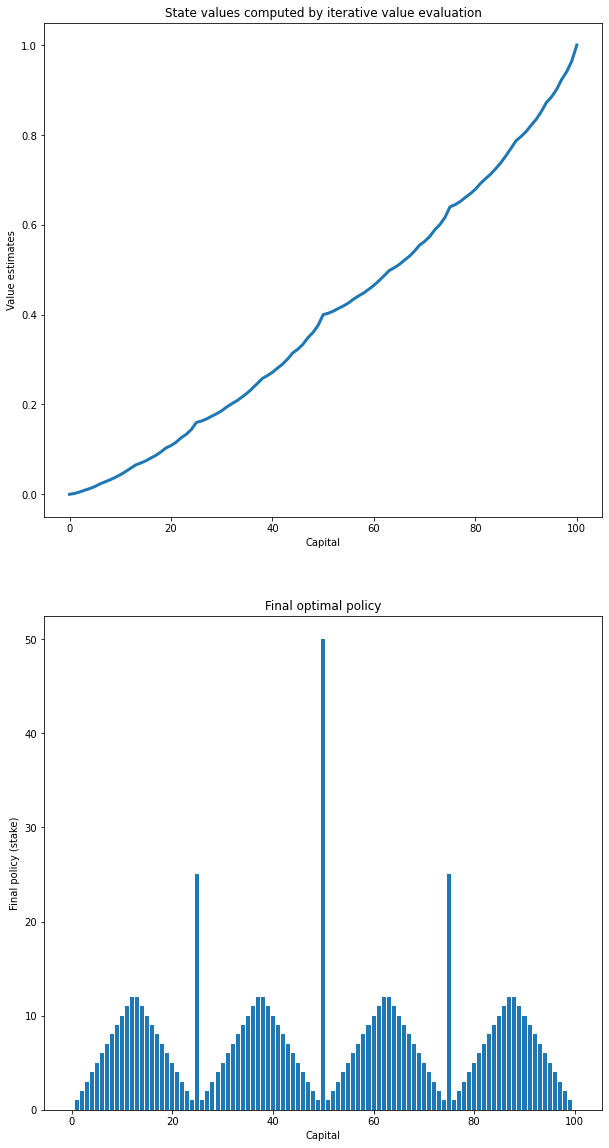

In [10]:
plot_results(state_values, policy)

## Monte Carlo methods

### Monte Carlo prediction
In Monte Carlo methods, the value function of a state is estimated by the average of the returns following *each visit* or *each first visit* to that state in a set of episodes. 

#### Incremental updates
Incremental mean: 
$$\mu_k=\frac{1}{k}\sum_{j=1}^kx_j=\mu_{k-1}+\frac{1}{k}(x_k-\mu_{k-1})$$

Incremental MC updates: 
$$v^j(s_t)=v^{j-1}(s_t)+\frac{1}{N(s_t)}(G^j_t-v^{j-1}(s_t))$$

where $G^j_t$ is the total return at j'th episode and $N(s_t)$ is the number of times state $s_t$ was visited - **the every-visit MC method**.

### Example: Blackjack
Blackjack is a card game. The goal is to obtain cards the sum of whose numerical values is as large as possible without exceeding 21. The face cards (JQK) count as 10 and the ace can count either as 1 or as 11. Consider the version in which each player competes independently against the dealer.  The game begins with 2 cards dealt to both dealer and player. One of the dealer's card is shown and the other is hidden. If the player has 21 immediately, it is called a natural. She then wins unless the dealer also has a natural. In that case, the game is a draw. If the player doesn't start with a natural, she can choose to either 'hit' or 'stick'. If the cards in hand exceeds 21, she loses. If she hits, she receives another card. If she sticks, it becomes the dealer's turn. 

This environment has been built in Gym, which is defined as following:
- Each game is an episode
- The cards are drawn from $\mathrm{deck}\in\{1,2,3,4,5,6,7,8,9,10,10,10,10\}$ with replacement
- The two actions are $a\in\{hit=1,stick=0\}$
- The rewards for win, draw and lose are $r\in\{+1,0,-1\}$
- The observation space has 3 variables: the players current sum,
the dealer's one showing card (1-10 where 1 is ace), and whether or not the player holds a usable ace (0 or 1).

We first consider a simple policy which chooses to hit when the sum of the player's cards in hand is equal to or less than 20 otherwise stick and evaluate it using the every-visit MC method. 

In [11]:
def policy(hand_sum):
    if hand_sum > 20:
        return 0
    else:
        return 1
    
def mc_policy_evaluation(state_count, r, value):
    return value + (r - value) / state_count


The player makes decisions on the basis of the three variables in the observation space: current sum (12-21), the dealer's one showing card (1-10) and whether or not she has a usable ace. Here, we focus on the setting where the current sum is at least 12. If it is smaller than 12, hit would be the optimal action. This makes for a total of 200 states. We therefore create two matrices to store the states for the two situations - with ace and without ace.  The row in each matrix indicates the player's cards and the column indicates the dealer's card.  

Import the environment and create arrays to store the state values and the number of appearances of each states, 


In [12]:
import gym
from mpl_toolkits.mplot3d import Axes3D
np.random.seed(123)

env = gym.make('Blackjack-v1', natural=False, sab=False)
values_usable_ace = np.zeros((10, 10))
values_no_usable_ace = np.zeros_like(values_usable_ace)
state_count_ace = np.zeros_like(values_usable_ace)
state_count_no_ace = np.zeros_like(state_count_ace)
episodes = 10000

Play the game for a number of episodes, count the state visits and record the observations and rewards:


In [13]:
for e in range(episodes):
        done = False
        obs = env.reset()
        state_history = []
        g = []
        
        obs = obs[0]
        if obs[0] < 11:
            done = True   

        state_history.append(obs)
        
        while not done:
            a = policy(obs[0])
            obs, r, done, info, prob = env.step(a)
            g.append(r)
            if done:
                break
            state_history.append(obs)

        final_reward = sum(g)

        for player_idx, dealer_idx, ace in state_history:
            player_idx -= 12
            dealer_idx -= 1

            if ace:
                state_count_ace[player_idx, dealer_idx] += 1.0
                values_usable_ace[player_idx, dealer_idx] = mc_policy_evaluation(state_count_ace[player_idx, dealer_idx],
                                                                                 final_reward,
                                                                                 values_usable_ace[player_idx, dealer_idx])
            else:
                state_count_no_ace[player_idx, dealer_idx] += 1.0
                values_no_usable_ace[player_idx, dealer_idx] = mc_policy_evaluation(state_count_no_ace[player_idx, dealer_idx],
                                                                                     final_reward,
                                                                                     values_no_usable_ace[player_idx, dealer_idx])

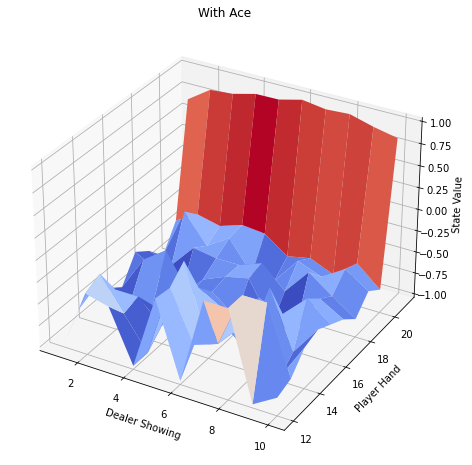

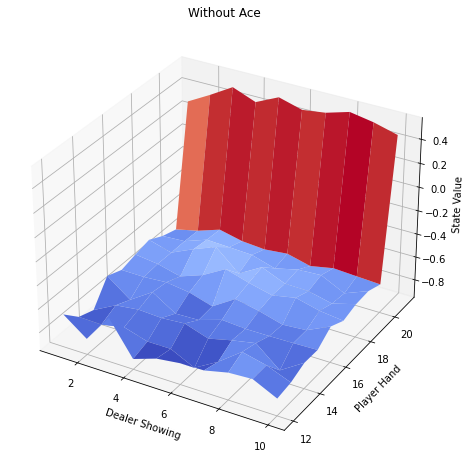

In [14]:
def plot_v(values, ace=True):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(projection='3d')

    x = np.arange(12, 22)
    y = np.arange(1, 11)

    X, Y = np.meshgrid(y, x)

    Z = values.reshape(X.shape)

    ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm, linewidth=1, rstride=1, cstride=1)
    if ace:
        ax.set_title("With Ace")
    else:
        ax.set_title("Without Ace")
    ax.set_xlabel("Dealer Showing")
    ax.set_ylabel("Player Hand")
    ax.set_zlabel("State Value")
    plt.show()

plot_v(values_usable_ace)
plot_v(values_no_usable_ace, ace=False)

### HW: Implement Monte Carlo control in the Blackjack example